In [ ]:
# Last amended: 24th August, 2019
# My folder: /home/ashok/Documents/spark/2.bike_sharing_dataset
# VM: lubuntu_spark.7z
# Ref: https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html
#      https://spark.apache.org/docs/latest/ml-guide.html

## Analyzing infant mortality dataset

### Objectives
----------
	To demonstrate creating an ML Pipeline to i) preprocess
	a dataset, ii) train a Machine Learning model, and iii) make
	predictions.

### Data:
-----
	The dataset contains incidence of infant mortality 
	along with 53 explanatory variables. The data has 
    45429 instances.
    Data Source: http://tomdrabas.com/data/LearningPySpark/

Fields :
	Features:
        infalive: Target features
        53 others: Related to child, mother and father
	

### Goal:
------
	We want to learn to predict whther an infant
	would survive. It is a classification problem
    with two target values: [1,0]
    
### Approach:
----------
	We will use Spark ML Pipelines, which help
	users piece together parts of a workflow such as
	feature processing and model training. We will also
	demonstrate model selection (a.k.a. hyperparameter
	tuning) using Cross Validation in order to fine-tune
	and improve our ML model.

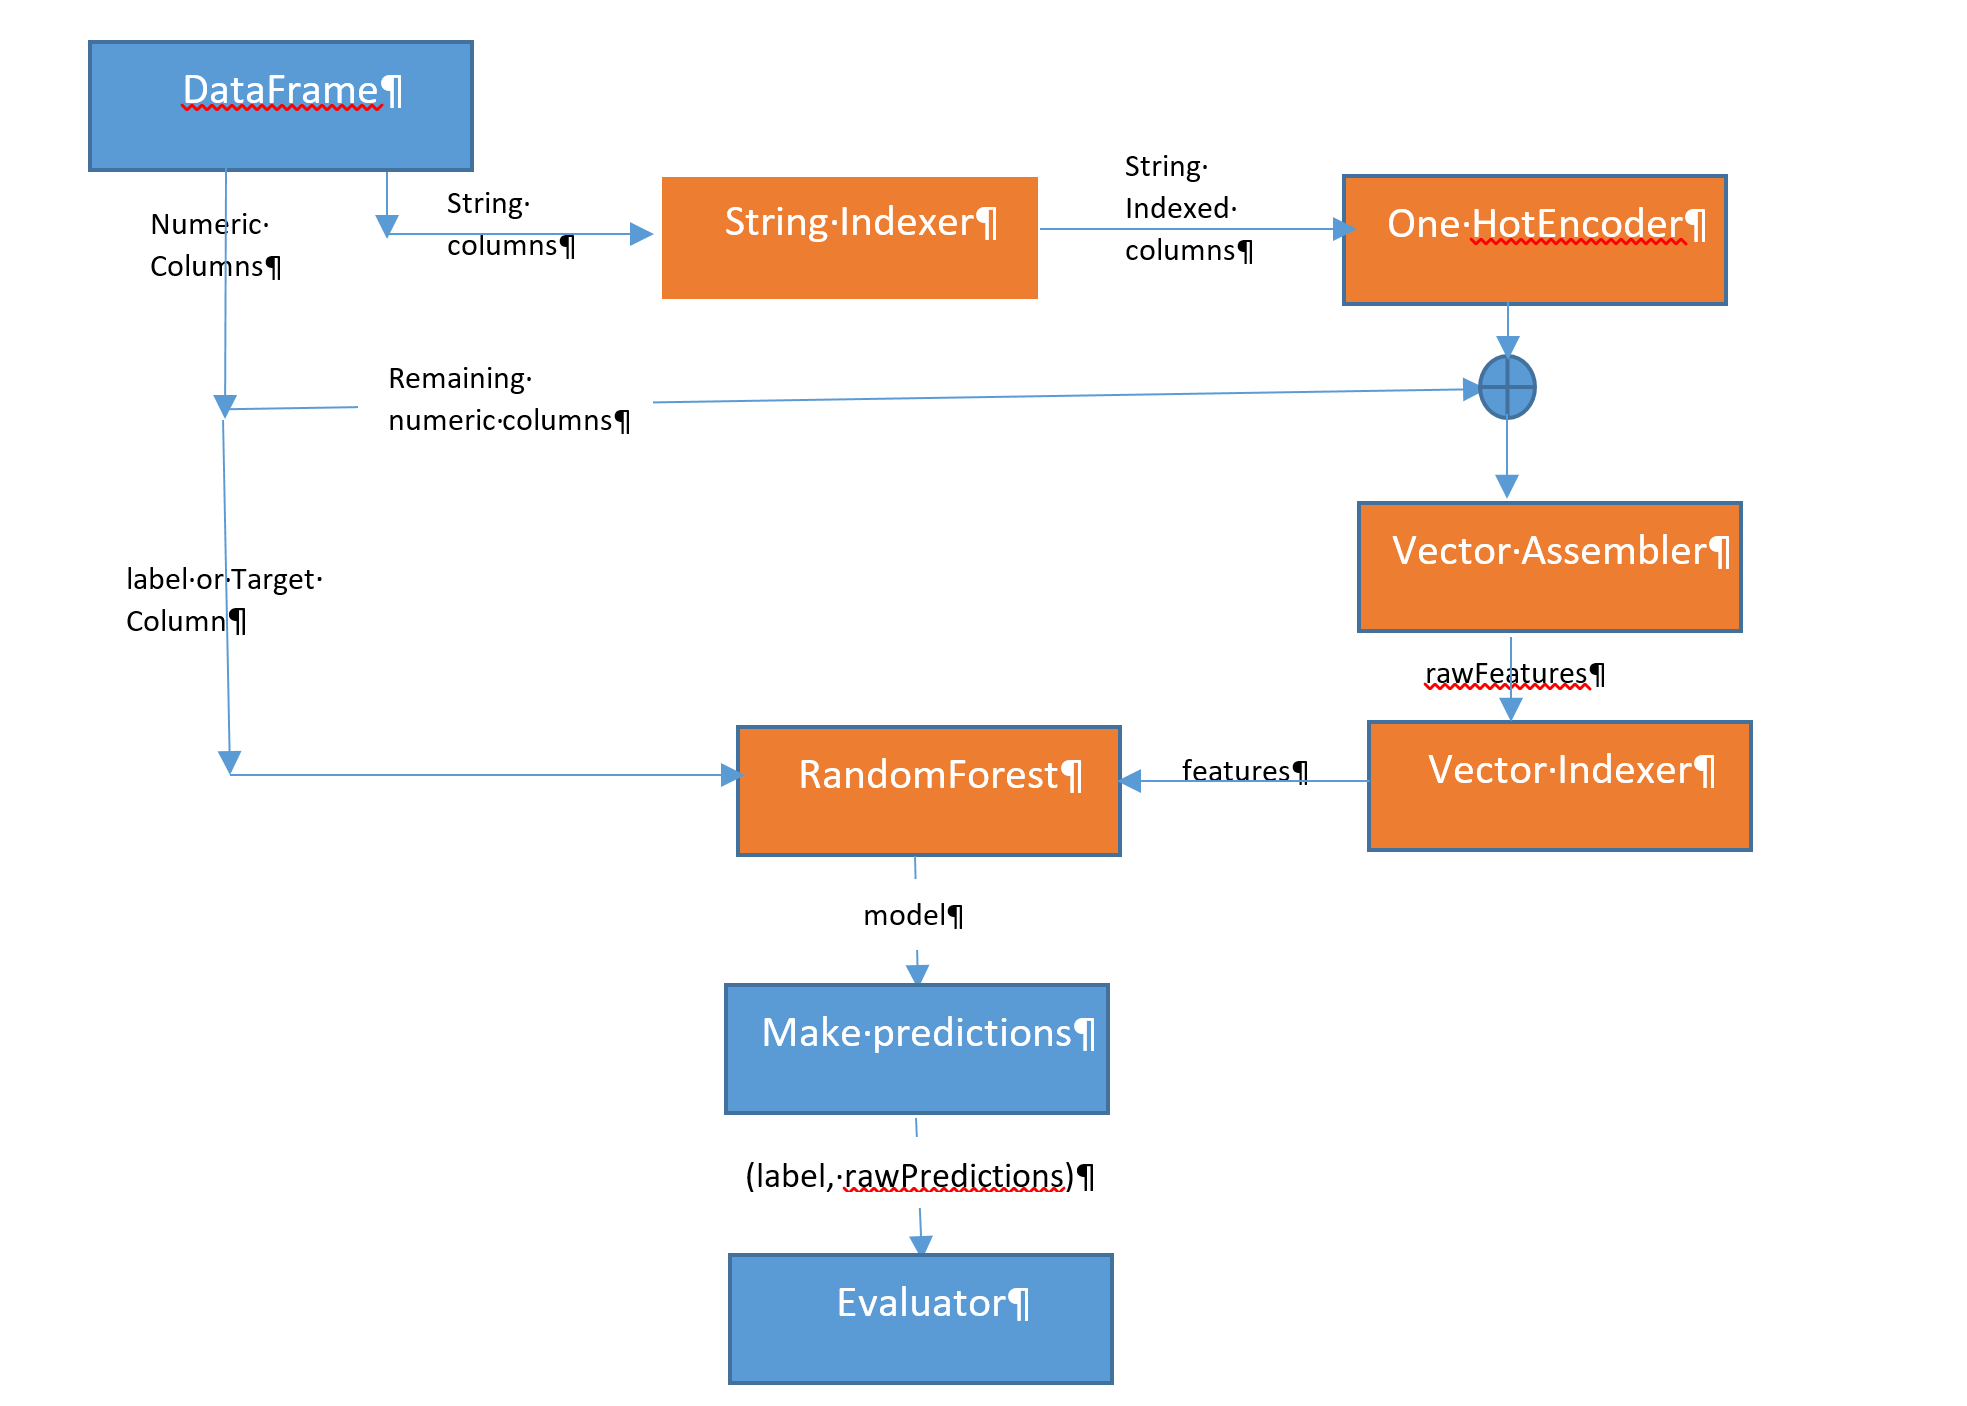

In [1]:
# 0.0 The following image displays data-processing pipeline
from IPython.display import Image
Image(filename='spark_ml_pipeline.png') 

In [ ]:

"""
AA.
===

Start hadoop:

           ./allstart.sh
BB.           
===
Copy following four commands and paste them in the terminal


      cd ~
      hdfs dfs -put /cdata/birth_data/births_train.csv  hdfs://localhost:9000/user/ashok/data_files
      hdfs dfs -ls hdfs://localhost:9000/user/ashok/data_files        
      cd ~


"""

In [2]:
# 1.0 Call libraries
# 1.0 Encode 'string' column to index-column. 
#     Indexing begins from 0.
from pyspark.ml.feature import StringIndexer
# 1.1 OHE an indexed column after StringIndexing
#     and create one another column
from pyspark.ml.feature import OneHotEncoderEstimator
# 1.2 Assemble numerical and OHE data in one column
from pyspark.ml.feature import VectorAssembler
# 1.3 Scale Vector-Assmbled data. Individual columns
#     will have to be scaled 'manually' using withColumn()
#     statement and writing your own scaling formula
from pyspark.ml.feature import StandardScaler
# 1.4 Vector Index one column assembled+scaled as above
from pyspark.ml.feature import VectorIndexer

# 1.5 Import ML estimator. It is a classification problem
from pyspark.ml.classification import RandomForestClassifier

# 1.6 Create a pipeline model for all stages
from pyspark.ml import Pipeline

# 1.7 Misc functions
# 1.7.1 Call an important group of sql functions
from pyspark.sql.functions import col,sum
# 1.7.2 Unlike in other languages, in spark
#       type-classes are to be separateky imported
#       They are not part of core classes or modules
from pyspark.sql.types import DoubleType

# 1.8 Binary classification results evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# 1.9
import os, time

In [3]:
# 2. Increase the width of notebook 
#    to display all columns of data
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
# 2.1 Show multiple outputs of a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# 3. Read, transform and understand the data
#      https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.csv
#    pyspark creates a spark-session variable: spark

df = spark.read.csv(
                   path = "hdfs://localhost:9000/user/ashok/data_files/births_train.csv",   # path to hadoop
                   header = True,
                   inferSchema= True,           # Infer datatypes automatically
                   sep = ","                   # Can be any character (check \t)
                   )


### Quick Explore data

In [6]:
# 3.1 Data shape
df.count()           # 45429
cols = df.columns
len(cols)            # 54
print(cols)

45429

54

['infalive', 'bthYear', 'bthMon', 'bthPlace', 'mothAge', 'mothRace', 'mothEdu', 'fathAge', 'fathEdu', 'monPrecare', 'cig', 'cig1', 'cig2', 'cig3', 'mothHt', 'mothBMI', 'mothPreWt', 'mothDeliveWt', 'mothWtGain', 'diabPre', 'diabGest', 'HypTensPre', 'HypTensGest', 'PrevBthPreterm', 'noRisk', 'No_infect', 'LaborInd', 'LaborAugm', 'streiods', 'antibiotics', 'anesthesia', 'delivMethod', 'attendant', 'apgar5', 'apgar5Recode', 'apgar10', 'apgar10Recode', 'sex', 'gestationWeeks', 'infWt', 'infAssist', 'infAssist2', 'infICU', 'infSurf', 'infAntibiotics', 'infSeizures', 'infnoAbnormalities', 'infAncep', 'infMenin', 'infLimb', 'infDonSyn', 'infChromoDisorder', 'infNoAnomalies', 'infBreastfeed']


In [7]:
# 3.2 We also cache the data so that
#     we only read it from disk once.

df.cache()

DataFrame[infalive: int, bthYear: int, bthMon: int, bthPlace: int, mothAge: int, mothRace: int, mothEdu: int, fathAge: int, fathEdu: int, monPrecare: int, cig: int, cig1: int, cig2: int, cig3: int, mothHt: int, mothBMI: int, mothPreWt: int, mothDeliveWt: int, mothWtGain: int, diabPre: string, diabGest: string, HypTensPre: string, HypTensGest: string, PrevBthPreterm: string, noRisk: int, No_infect: int, LaborInd: string, LaborAugm: string, streiods: string, antibiotics: string, anesthesia: string, delivMethod: int, attendant: int, apgar5: int, apgar5Recode: int, apgar10: int, apgar10Recode: int, sex: string, gestationWeeks: int, infWt: int, infAssist: string, infAssist2: string, infICU: string, infSurf: string, infAntibiotics: string, infSeizures: string, infnoAbnormalities: int, infAncep: string, infMenin: string, infLimb: string, infDonSyn: string, infChromoDisorder: string, infNoAnomalies: int, infBreastfeed: string]

In [8]:
# 3.3 Show database in parts.
#     First column is target.
#     Few columns are strings
#     Most columns appear to be integers

df.select(cols[:15]).show(3)
df.select(cols[15:25]).show(3)
df.select(cols[25:35]).show(3)
df.select(cols[35:45]).show(3)
df.select(cols[45:]).show(3)

+--------+-------+------+--------+-------+--------+-------+-------+-------+----------+---+----+----+----+------+
|infalive|bthYear|bthMon|bthPlace|mothAge|mothRace|mothEdu|fathAge|fathEdu|monPrecare|cig|cig1|cig2|cig3|mothHt|
+--------+-------+------+--------+-------+--------+-------+-------+-------+----------+---+----+----+----+------+
|       0|   2015|     2|       1|     29|       3|      9|     99|      9|         4| 99|  99|  99|  99|    99|
|       0|   2015|     2|       1|     22|       1|      3|     29|      4|         1|  0|   0|   0|   0|    65|
|       0|   2015|     2|       1|     38|       1|      4|     40|      3|         1|  0|   0|   0|   0|    63|
+--------+-------+------+--------+-------+--------+-------+-------+-------+----------+---+----+----+----+------+
only showing top 3 rows

+-------+---------+------------+----------+-------+--------+----------+-----------+--------------+------+
|mothBMI|mothPreWt|mothDeliveWt|mothWtGain|diabPre|diabGest|HypTensPre|HypTens

In [22]:
# 3.4 Check missing values:
#     https://stackoverflow.com/questions/44413132/count-the-number-of-missing-values-in-a-dataframe-spark
#     Try to understand this one line statement. It is educative.
#     Note that the statement is 'tuple comprehension' rather than usual list-comprehension.
#     Try replacing alias(c) with alias('missing')

df.select(*(sum(df[c].isNull().cast("int")).alias("mis") for c in cols[5:15])).show() 

+---+---+---+---+---+---+---+---+---+---+
|mis|mis|mis|mis|mis|mis|mis|mis|mis|mis|
+---+---+---+---+---+---+---+---+---+---+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+---+---+---+---+---+---+---+---+---+---+



In [10]:
   
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[15:25])).show()
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[25:35])).show()
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[35:45])).show()
df.select(*(sum(df[c].isNull().cast("int")).alias(c) for c in cols[45:])).show()

+-------+---------+------------+----------+-------+--------+----------+-----------+--------------+------+
|mothBMI|mothPreWt|mothDeliveWt|mothWtGain|diabPre|diabGest|HypTensPre|HypTensGest|PrevBthPreterm|noRisk|
+-------+---------+------------+----------+-------+--------+----------+-----------+--------------+------+
|      0|        0|           0|         0|      0|       0|         0|          0|             0|     0|
+-------+---------+------------+----------+-------+--------+----------+-----------+--------------+------+

+---------+--------+---------+--------+-----------+----------+-----------+---------+------+------------+
|No_infect|LaborInd|LaborAugm|streiods|antibiotics|anesthesia|delivMethod|attendant|apgar5|apgar5Recode|
+---------+--------+---------+--------+-----------+----------+-----------+---------+------+------------+
|        0|       0|        0|       0|          0|         0|          0|        0|     0|           0|
+---------+--------+---------+--------+----------

In [11]:
# 3.5 Rename target column 'infalive' to 'label'
#     This target name is used, by default, by ML algorithms 

df = df.withColumnRenamed('infalive', 'label')
print(df.columns)

['label', 'bthYear', 'bthMon', 'bthPlace', 'mothAge', 'mothRace', 'mothEdu', 'fathAge', 'fathEdu', 'monPrecare', 'cig', 'cig1', 'cig2', 'cig3', 'mothHt', 'mothBMI', 'mothPreWt', 'mothDeliveWt', 'mothWtGain', 'diabPre', 'diabGest', 'HypTensPre', 'HypTensGest', 'PrevBthPreterm', 'noRisk', 'No_infect', 'LaborInd', 'LaborAugm', 'streiods', 'antibiotics', 'anesthesia', 'delivMethod', 'attendant', 'apgar5', 'apgar5Recode', 'apgar10', 'apgar10Recode', 'sex', 'gestationWeeks', 'infWt', 'infAssist', 'infAssist2', 'infICU', 'infSurf', 'infAntibiotics', 'infSeizures', 'infnoAbnormalities', 'infAncep', 'infMenin', 'infLimb', 'infDonSyn', 'infChromoDisorder', 'infNoAnomalies', 'infBreastfeed']


In [12]:
# 3.6 Show database structure.
#     Two types: 'int' and 'string'

dftype = df.dtypes
print(dftype)

[('label', 'int'), ('bthYear', 'int'), ('bthMon', 'int'), ('bthPlace', 'int'), ('mothAge', 'int'), ('mothRace', 'int'), ('mothEdu', 'int'), ('fathAge', 'int'), ('fathEdu', 'int'), ('monPrecare', 'int'), ('cig', 'int'), ('cig1', 'int'), ('cig2', 'int'), ('cig3', 'int'), ('mothHt', 'int'), ('mothBMI', 'int'), ('mothPreWt', 'int'), ('mothDeliveWt', 'int'), ('mothWtGain', 'int'), ('diabPre', 'string'), ('diabGest', 'string'), ('HypTensPre', 'string'), ('HypTensGest', 'string'), ('PrevBthPreterm', 'string'), ('noRisk', 'int'), ('No_infect', 'int'), ('LaborInd', 'string'), ('LaborAugm', 'string'), ('streiods', 'string'), ('antibiotics', 'string'), ('anesthesia', 'string'), ('delivMethod', 'int'), ('attendant', 'int'), ('apgar5', 'int'), ('apgar5Recode', 'int'), ('apgar10', 'int'), ('apgar10Recode', 'int'), ('sex', 'string'), ('gestationWeeks', 'int'), ('infWt', 'int'), ('infAssist', 'string'), ('infAssist2', 'string'), ('infICU', 'string'), ('infSurf', 'string'), ('infAntibiotics', 'string')

In [13]:
# 4.1 Get a list of 'int' cols:

int_cols =   [ i[0] for i in df.dtypes if i[1] == 'int' ] 
print(int_cols)

['label', 'bthYear', 'bthMon', 'bthPlace', 'mothAge', 'mothRace', 'mothEdu', 'fathAge', 'fathEdu', 'monPrecare', 'cig', 'cig1', 'cig2', 'cig3', 'mothHt', 'mothBMI', 'mothPreWt', 'mothDeliveWt', 'mothWtGain', 'noRisk', 'No_infect', 'delivMethod', 'attendant', 'apgar5', 'apgar5Recode', 'apgar10', 'apgar10Recode', 'gestationWeeks', 'infWt', 'infnoAbnormalities', 'infNoAnomalies']


In [14]:
# 4.2 Cast 'int' columns to 'double'
#     Needed by VectorIndexer.
#     Also it is a safe step

for colm in int_cols:
    df = df.withColumn(colm, df[colm].cast(DoubleType()))

print(df.dtypes)

[('label', 'double'), ('bthYear', 'double'), ('bthMon', 'double'), ('bthPlace', 'double'), ('mothAge', 'double'), ('mothRace', 'double'), ('mothEdu', 'double'), ('fathAge', 'double'), ('fathEdu', 'double'), ('monPrecare', 'double'), ('cig', 'double'), ('cig1', 'double'), ('cig2', 'double'), ('cig3', 'double'), ('mothHt', 'double'), ('mothBMI', 'double'), ('mothPreWt', 'double'), ('mothDeliveWt', 'double'), ('mothWtGain', 'double'), ('diabPre', 'string'), ('diabGest', 'string'), ('HypTensPre', 'string'), ('HypTensGest', 'string'), ('PrevBthPreterm', 'string'), ('noRisk', 'double'), ('No_infect', 'double'), ('LaborInd', 'string'), ('LaborAugm', 'string'), ('streiods', 'string'), ('antibiotics', 'string'), ('anesthesia', 'string'), ('delivMethod', 'double'), ('attendant', 'double'), ('apgar5', 'double'), ('apgar5Recode', 'double'), ('apgar10', 'double'), ('apgar10Recode', 'double'), ('sex', 'string'), ('gestationWeeks', 'double'), ('infWt', 'double'), ('infAssist', 'string'), ('infAssist2

############# Creating transformation objects  ######################
1.             StringIndexer
    - Inputs & outputs are Column names
-        OneHotEncoderEstimator
    - Inputs & outputs are Column names
-             VectorAssembler
    - Inputs & outputs: Column names
-             Scaler
    - Inputs & outputs are Column names
-             VectorIndexer
    - Inputs & outputs are Column names
-             RandomForest Estimator
    - Inputs: Column name; Output is model

In [15]:
# 4.3 Get list of String columns and for each, 
#     column create a separate StrinIndexer object
#     to fit and transform that column.
#     So we will have as many Stringindexed objects as there are 
#     'string' type columns

cat_columns = [ c[0] for c in df.dtypes if c[1] == "string"]

# 4.4 Create StringIndexer object. Two sample output 
#     column names are: 'stringindexed_infBreastfeed' 'stringindexed_infMenin'

stringindexer_stages = [ StringIndexer(inputCol=c, outputCol='stringindexed_' + c) for c in cat_columns]
stringindexer_stages

[StringIndexer_191a70eeb2a4,
 StringIndexer_43fcfae080a9,
 StringIndexer_1bd41cee49e6,
 StringIndexer_bd747b43fe7d,
 StringIndexer_c9c052342adc,
 StringIndexer_1466a466f92e,
 StringIndexer_a8ef4992f6d2,
 StringIndexer_c79940056209,
 StringIndexer_0d4861ac9493,
 StringIndexer_d9e061b1f4e5,
 StringIndexer_fc8cf0a72809,
 StringIndexer_7ae99ca97481,
 StringIndexer_8acdef22a1aa,
 StringIndexer_1fea4e99e325,
 StringIndexer_59829197954c,
 StringIndexer_49201d89b12f,
 StringIndexer_cf1cc2d63fb6,
 StringIndexer_31ac8d82d1b2,
 StringIndexer_23f4f571e410,
 StringIndexer_138c4d49fc54,
 StringIndexer_8d7ebd2d806b,
 StringIndexer_a77520bad7a3,
 StringIndexer_b850b3a2c2d8]

In [17]:
# 4.5 Create OneHotEncoderEstimator object to transform Stringdexed columns
#     to OneHotEncoded form

in_cols = ['stringindexed_' + c for c in cat_columns]
ohe_cols = ['onehotencoded_' + c  for c in cat_columns]
onehotencoder_stages = [OneHotEncoderEstimator(inputCols=in_cols, outputCols=ohe_cols)]
onehotencoder_stages

[OneHotEncoderEstimator_e949bf5d0483]

In [18]:
# 5 Which columns are now explanatory variables? 
#     Type: double and OHE Columns

double_cols =   [  i[0] for i in df.dtypes if i[1] == 'double' ] 

# 5.1 Remove 'target' column from this list:

double_cols.remove('label')   # earlier name 'infalive'

# 5.2 Create a combined list of double + ohe_cols

featuresCols = double_cols + ohe_cols
print(featuresCols)
len(featuresCols)       # 53

['bthYear', 'bthMon', 'bthPlace', 'mothAge', 'mothRace', 'mothEdu', 'fathAge', 'fathEdu', 'monPrecare', 'cig', 'cig1', 'cig2', 'cig3', 'mothHt', 'mothBMI', 'mothPreWt', 'mothDeliveWt', 'mothWtGain', 'noRisk', 'No_infect', 'delivMethod', 'attendant', 'apgar5', 'apgar5Recode', 'apgar10', 'apgar10Recode', 'gestationWeeks', 'infWt', 'infnoAbnormalities', 'infNoAnomalies', 'onehotencoded_diabPre', 'onehotencoded_diabGest', 'onehotencoded_HypTensPre', 'onehotencoded_HypTensGest', 'onehotencoded_PrevBthPreterm', 'onehotencoded_LaborInd', 'onehotencoded_LaborAugm', 'onehotencoded_streiods', 'onehotencoded_antibiotics', 'onehotencoded_anesthesia', 'onehotencoded_sex', 'onehotencoded_infAssist', 'onehotencoded_infAssist2', 'onehotencoded_infICU', 'onehotencoded_infSurf', 'onehotencoded_infAntibiotics', 'onehotencoded_infSeizures', 'onehotencoded_infAncep', 'onehotencoded_infMenin', 'onehotencoded_infLimb', 'onehotencoded_infDonSyn', 'onehotencoded_infChromoDisorder', 'onehotencoded_infBreastfeed

53

In [24]:
# 6   Create an instance of VectorAssembler class.
#          This object will be used to assemble all featureCols
#          (a list of columns) into one column with name
#           'rawFeatures'

vectorassembler = VectorAssembler(
                                  inputCols=featuresCols,
                                  outputCol="rawFeatures"
                                 )

In [25]:
# 6.1 Create an object to scale vectorassembled data
#     All the data is of type 'double'.
#     StandardScaler will only scale columns of type 'vector'
scaler = StandardScaler(inputCol="rawFeatures",
                        outputCol="scaledFeatures",
                        withStd=True,
                        withMean=True
                       )

In [26]:
# 7  Create an object to perform Vector Indexing 
#    that is automatically discover which numerical columns 
#    are categorical columns
#    Instantiate the object first
vectorindexer = VectorIndexer(inputCol="scaledFeatures",
                              outputCol="features",
                              maxCategories=5       # Reindex, if no of distinct values less than 5
                              )

In [27]:
# 8   Instantiate the classifier object
#     Takes the "features" column and learns to predict "label"
#     RandomForestClassifier(featuresCol='features',labelCol='label', predictionCol='prediction',
#                            probabilityCol='probability', rawPredictionCol='rawPrediction',
#                            maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0,
#                            maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10,
#                            impurity='gini', numTrees=20, featureSubsetStrategy='auto',
#                            seed=None, subsamplingRate=1.0)

rf = RandomForestClassifier(
                            labelCol="label",         # This is default name
                            featuresCol="features",   # This is ALSO default name
                            numTrees=100
                            )


In [ ]:
############# Data splitting and modeling ######################

In [28]:
# 9. Split the dataset randomly into 70% for
#    training and 30% for testing.
train, test = df.randomSplit([0.7, 0.3])

# 8.1
print(train.count()/df.count())
print(test.count()/df.count())

0.7025248189482489
0.2974751810517511


In [30]:
# 9.2 Create pipeline model
pipeline = Pipeline(stages=[                       \
                            *stringindexer_stages, \
                            *onehotencoder_stages, \
                            vectorassembler,       \
                            scaler,                \
                            vectorindexer,         \
                            rf                     \
                           ]                       \
                   )

In [31]:
# 10. Run the pipeline. This will run complete pipe
#     including transform() methods of vectorassembler & vectorindexer
#     but transform() method of cv is not run. For cv,
#     it is just modeling and fitting; no transformation.
#    CONSUMES LOTS OF MEMORY. THINGS MAY SLOW DOWN
#    OR CONNECTIONS MAY BREAK

start = time.time()
pipelineModel = pipeline.fit(train)
end = time.time()
(end - start)/60           # Takes 3 minutes


2.5169273177782694

############# Predictions & evaluation  ######################

In [32]:

# 10.1 Make predictions on test data.
#      Note it is NOT pipelineModel.predict()

predictions = pipelineModel.transform(test)
type(predictions)               # Spark Dataframe

# 10.2 See the last five columns
print(predictions.columns)

pyspark.sql.dataframe.DataFrame

['label', 'bthYear', 'bthMon', 'bthPlace', 'mothAge', 'mothRace', 'mothEdu', 'fathAge', 'fathEdu', 'monPrecare', 'cig', 'cig1', 'cig2', 'cig3', 'mothHt', 'mothBMI', 'mothPreWt', 'mothDeliveWt', 'mothWtGain', 'diabPre', 'diabGest', 'HypTensPre', 'HypTensGest', 'PrevBthPreterm', 'noRisk', 'No_infect', 'LaborInd', 'LaborAugm', 'streiods', 'antibiotics', 'anesthesia', 'delivMethod', 'attendant', 'apgar5', 'apgar5Recode', 'apgar10', 'apgar10Recode', 'sex', 'gestationWeeks', 'infWt', 'infAssist', 'infAssist2', 'infICU', 'infSurf', 'infAntibiotics', 'infSeizures', 'infnoAbnormalities', 'infAncep', 'infMenin', 'infLimb', 'infDonSyn', 'infChromoDisorder', 'infNoAnomalies', 'infBreastfeed', 'stringindexed_diabPre', 'stringindexed_diabGest', 'stringindexed_HypTensPre', 'stringindexed_HypTensGest', 'stringindexed_PrevBthPreterm', 'stringindexed_LaborInd', 'stringindexed_LaborAugm', 'stringindexed_streiods', 'stringindexed_antibiotics', 'stringindexed_anesthesia', 'stringindexed_sex', 'stringindexe

In [33]:
# 10.3 Check the types of last 
#      few columns that you have created
#      Some are 'vector' types
print(predictions.dtypes)

[('label', 'double'), ('bthYear', 'double'), ('bthMon', 'double'), ('bthPlace', 'double'), ('mothAge', 'double'), ('mothRace', 'double'), ('mothEdu', 'double'), ('fathAge', 'double'), ('fathEdu', 'double'), ('monPrecare', 'double'), ('cig', 'double'), ('cig1', 'double'), ('cig2', 'double'), ('cig3', 'double'), ('mothHt', 'double'), ('mothBMI', 'double'), ('mothPreWt', 'double'), ('mothDeliveWt', 'double'), ('mothWtGain', 'double'), ('diabPre', 'string'), ('diabGest', 'string'), ('HypTensPre', 'string'), ('HypTensGest', 'string'), ('PrevBthPreterm', 'string'), ('noRisk', 'double'), ('No_infect', 'double'), ('LaborInd', 'string'), ('LaborAugm', 'string'), ('streiods', 'string'), ('antibiotics', 'string'), ('anesthesia', 'string'), ('delivMethod', 'double'), ('attendant', 'double'), ('apgar5', 'double'), ('apgar5Recode', 'double'), ('apgar10', 'double'), ('apgar10Recode', 'double'), ('sex', 'string'), ('gestationWeeks', 'double'), ('infWt', 'double'), ('infAssist', 'string'), ('infAssist2

In [34]:
# 10.4 Show all columns including predicted column
#      featuresCols: See para 6.2 above
#      What is meant by rawPerdiction. Please see this link:
#      https://stackoverflow.com/a/37909854

predictions.select("label", "prediction", 'rawPrediction', 'probability').show(4, False)

+-----+----------+--------------------------------------+-----------------------------------------+
|label|prediction|rawPrediction                         |probability                              |
+-----+----------+--------------------------------------+-----------------------------------------+
|0.0  |0.0       |[97.14871887443346,2.8512811255665245]|[0.9714871887443347,0.02851281125566525] |
|0.0  |0.0       |[96.82964044770844,3.170359552291543] |[0.9682964044770845,0.031703595522915434]|
|0.0  |0.0       |[93.92574201646477,6.0742579835352215]|[0.9392574201646477,0.06074257983535222] |
|0.0  |0.0       |[97.0459511400391,2.95404885996089]   |[0.9704595114003911,0.0295404885996089]  |
+-----+----------+--------------------------------------+-----------------------------------------+
only showing top 4 rows



In [35]:
# 10.5 Evaluate results
# Ref: http://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator
# Create evaluator object.  

evaluator = BinaryClassificationEvaluator(
                                          rawPredictionCol='rawPrediction', # This is default name
                                          labelCol='label',                 # This is defalut name
                                          metricName='areaUnderROC'         # This is default metirc
                                          )

areaUnderROC = evaluator.evaluate(predictions)
areaUnderROC

0.9753036336801576

In [48]:
evaluator.write()

In [ ]:
################### I am done ###################

In [ ]:
################### Advanced for debugging ###################

In [ ]:
## ADVANCED FOR DEBUGGING
# 11.  Should you want an intermediate pipeline to debug the code
#      or to see what all is happening here is the quick code
pipeline1 = Pipeline(stages=[*stringindexer_stages,*onehotencoder_stages,vectorassembler, scaler, vectorindexer])
pipelineModelx = pipeline1.fit(df)  # Learn train
tr = pipelineModelx.transform(df)   # Transform train through all stages
cls = tr.columns             # List of columns in this dataframe  
numb = len(tr.columns)
tr.select(cls[(numb-4): ]).show(3)  # See Ist four columns

In [ ]:
# 11.1 Further, should you want to access
#      some attribute of an intermediate 
#      stage-model, here is the way:

# 11.1.1 What are pipeline model stages:
pipelineModelx.stages

# 11.1.2 How to access VectorIndexer model:
pipelineModelx.stages[-1].categoryMaps

# 11.1.3 So VectorIndexer transformed how many columns:
len(pipelineModelx.stages[-1].categoryMaps)


################### I am done ###################